In [1]:
import matplotlib.pyplot as plt
from skimage import io
from skimage.segmentation import quickshift
from skimage.segmentation import mark_boundaries
import random
import numpy as np
import torch
from torchvision import models
from torchvision.transforms import v2
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm
import urllib.request
from io import BytesIO

In [2]:
# preprocessing the image according to inceptionv3
def preprocess_image_inception(img):
    transform = v2.Compose([v2.Resize(299),
                            v2.CenterCrop(299),
                            v2.ToImage(), 
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    img_tensor = transform(img)
    return img_tensor

# preprocessing the image according to segmentation
def preprocess_image_segment(img):
    transform = v2.Compose([v2.Resize(299),
                            v2.CenterCrop(299)
                            ])
    img = transform(img)
    img_np = np.array(img)
    return img_np


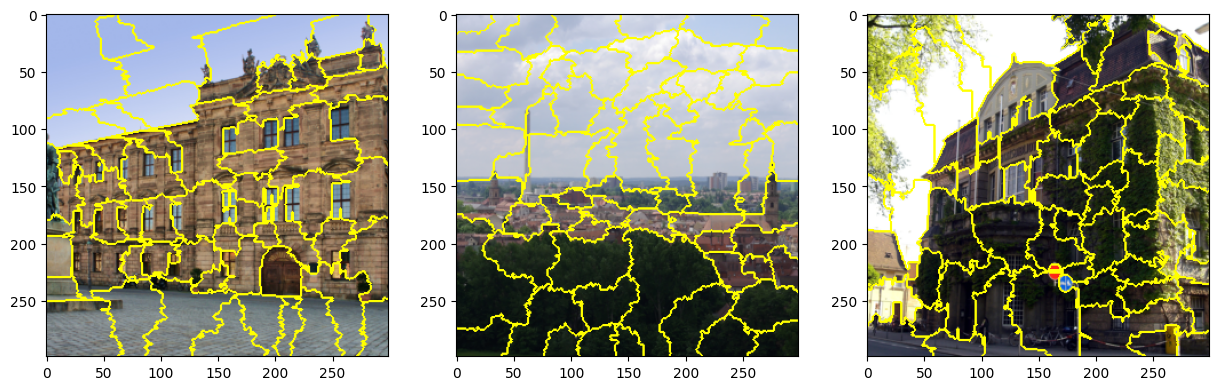

In [3]:
# loading the image and displaying the segments

img1_url = 'https://upload.wikimedia.org/wikipedia/commons/2/2b/Schloss-Erlangen02.JPG'
with urllib.request.urlopen(img1_url) as url:
    img1 = Image.open(BytesIO(url.read()))
    
img2_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0c/Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG'
with urllib.request.urlopen(img2_url) as url:
    img2 = Image.open(BytesIO(url.read()))

img3_url = 'https://upload.wikimedia.org/wikipedia/commons/c/cc/Alte-universitaets-bibliothek_universitaet-erlangen.jpg'
with urllib.request.urlopen(img3_url) as url:
    img3 = Image.open(BytesIO(url.read()))


img1_np = preprocess_image_segment(img1)
segments1 = quickshift(img1_np, kernel_size=4, max_dist=200, ratio=0.2)

img2_np = preprocess_image_segment(img2)
segments2 = quickshift(img2_np, kernel_size=4, max_dist=200, ratio=0.2)

img3_np = preprocess_image_segment(img3)
segments3 = quickshift(img3_np, kernel_size=4, max_dist=200, ratio=0.2)


fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].imshow(mark_boundaries(img1_np,segments1))
axes[1].imshow(mark_boundaries(img2_np,segments2))
axes[2].imshow(mark_boundaries(img3_np,segments3))
plt.show()

In [4]:
# function for generating the purtubed samples 
# here, I have taken number of pertubations = 300 samples

def generate_pertubed_samples(original_img, segments, num_pertubed, num_superpixels):
    random.seed(0)
    pertubed_images = []
    binary_masks = []
    p = 0.5
    for _ in range(num_pertubed):
        mask = np.random.binomial(1, p, size=num_superpixels)
        binary_masks.append(mask)
        temp_img = original_img.copy()

        for i in range(num_superpixels):
            if mask[i] == 0:
                temp_img[segments == i] = 0
        pertubed_img = Image.fromarray(temp_img)
        pertubed_img_tensor = preprocess_image_inception(pertubed_img).unsqueeze(0)
        pertubed_images.append(pertubed_img_tensor)

    # stack all the images in a single tensor
    pertubed_images_tensor = torch.cat(pertubed_images)
    
    binary_masks = np.array(binary_masks)
    return pertubed_images_tensor, binary_masks

num_superpixels1 = len(np.unique(segments1))
num_superpixels2 = len(np.unique(segments2))
num_superpixels3 = len(np.unique(segments3))

num_pertubed = 300
pertubed_images_tensor1, binary_masks1 = generate_pertubed_samples(img1_np, segments1, num_pertubed=num_pertubed, num_superpixels=num_superpixels1)
pertubed_images_tensor2, binary_masks2 = generate_pertubed_samples(img2_np, segments2, num_pertubed=num_pertubed, num_superpixels=num_superpixels2)
pertubed_images_tensor3, binary_masks3 = generate_pertubed_samples(img3_np, segments3, num_pertubed=num_pertubed, num_superpixels=num_superpixels3)

In [5]:
# function for getting the top1 and top2 prediction from inception v3

model = models.inception_v3(pretrained=True)
model.eval()

def get_top_pred(output, topk=2):
    probabilities = torch.nn.functional.softmax(output, dim=1)
    top_probs, top_indices = probabilities.topk(topk, dim=1, largest=True, sorted=True)
    return top_probs, top_indices

with torch.no_grad():
    outputs1 = model(pertubed_images_tensor1)
    outputs2 = model(pertubed_images_tensor2)
    outputs3 = model(pertubed_images_tensor3)

top_probs1, top_indices1 = get_top_pred(outputs1, topk=2)
top_probs2, top_indices2 = get_top_pred(outputs2, topk=2)
top_probs3, top_indices3 = get_top_pred(outputs3, topk=2)

C:\Users\samar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\samar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# compare the distance between original image and purtubed images

def get_cosine_distance(img_np, num_pertubed, pertubed_images_tensor):
    img_tensor = preprocess_image_inception(img_np)
    original_img_flat = img_tensor.flatten().numpy()
    
    weights = np.zeros(num_pertubed)
    #kernel width parameter
    sigma = 0.25
    for i in range(num_pertubed):
        pertubed_img_flat = pertubed_images_tensor[i].flatten().numpy()
    
        similarity = cosine_similarity([original_img_flat], [pertubed_img_flat])[0][0]
        dist = 1 - similarity
        weight = np.exp(-dist**2/ sigma**2)
        weights[i] = weight
    return weights

weights1 = get_cosine_distance(img1_np, num_pertubed, pertubed_images_tensor1)
weights2 = get_cosine_distance(img2_np, num_pertubed, pertubed_images_tensor2)
weights3 = get_cosine_distance(img3_np, num_pertubed, pertubed_images_tensor3)


In [7]:
# compute weighted linear regression

def weighted_linear_regression(binary_masks, top_probs, weights):
    feature_matrix = binary_masks
    feature_matrix_with_intercept = sm.add_constant(feature_matrix)
    
    top_1_probs = np.array(top_probs[:,0])
    top_2_probs = np.array(top_probs[:,1])
    
    weighted_model1 = sm.WLS(top_1_probs, feature_matrix_with_intercept, weights=weights)
    weighted_model2 = sm.WLS(top_2_probs, feature_matrix_with_intercept, weights=weights)

    results1 = weighted_model1.fit()
    results2 = weighted_model2.fit()
    
    coef_top1 = results1.params[1:]
    coef_top2 = results2.params[1:]
    
    return coef_top1, coef_top2

coef_img1_top1, coef_img1_top2 = weighted_linear_regression(binary_masks1, top_probs1, weights1)
coef_img2_top1, coef_img2_top2 = weighted_linear_regression(binary_masks2, top_probs2, weights2)
coef_img3_top1, coef_img3_top2 = weighted_linear_regression(binary_masks3, top_probs3, weights3)


In [8]:
# get the top-4 important superpixels
def get_imp_superpixels(coef, segments, img_np): 
    num_top_superpixels = 4
    important_superpixels_indices = np.argsort(-np.abs(coef))[:num_top_superpixels]
    
    mask = np.zeros_like(segments, dtype = np.uint8)
    
    for superpixel in important_superpixels_indices:
        mask[segments == superpixel] = 1
    
    highlighted_img = img_np*mask[:,:, np.newaxis]
    return highlighted_img

highlighted_img1_top1 = get_imp_superpixels(coef_img1_top1, segments1, img1_np)
highlighted_img1_top2 = get_imp_superpixels(coef_img1_top2, segments1, img1_np)

highlighted_img2_top1 = get_imp_superpixels(coef_img2_top1, segments2, img2_np)
highlighted_img2_top2 = get_imp_superpixels(coef_img2_top2, segments2, img2_np)

highlighted_img3_top1 = get_imp_superpixels(coef_img3_top1, segments3, img3_np)
highlighted_img3_top2 = get_imp_superpixels(coef_img3_top2, segments3, img3_np)


In [9]:
# get the original image prediction
def get_original_prediction(img_np):
    original_img_tensor = preprocess_image_inception(img_np).unsqueeze(0)
    
    with torch.no_grad():
        original_output = model(original_img_tensor)
    
    probabilities = torch.nn.functional.softmax(original_output, dim=1)
    top_probs, top_indices = probabilities.topk(2, dim=1, largest=True, sorted=True)
    
    
    LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    labels = requests.get(LABELS_URL).json()
    
    top1_prob = top_probs[0, 0].item()
    top1_class = labels[top_indices[0, 0].item()]
    top2_prob = top_probs[0, 1].item()
    top2_class = labels[top_indices[0, 1].item()]

    return top1_class, top1_prob, top2_class, top2_prob

img1_top1_cls, img1_top1_prob, img1_top2_cls, img1_top2_prob = get_original_prediction(img1_np)
img2_top1_cls, img2_top1_prob, img2_top2_cls, img2_top2_prob = get_original_prediction(img2_np)
img3_top1_cls, img3_top1_prob, img3_top2_cls, img3_top2_prob = get_original_prediction(img3_np)


Top-1 Prediction: palace (Probability: 0.6692)
Top-2 Prediction: castle (Probability: 0.1195)


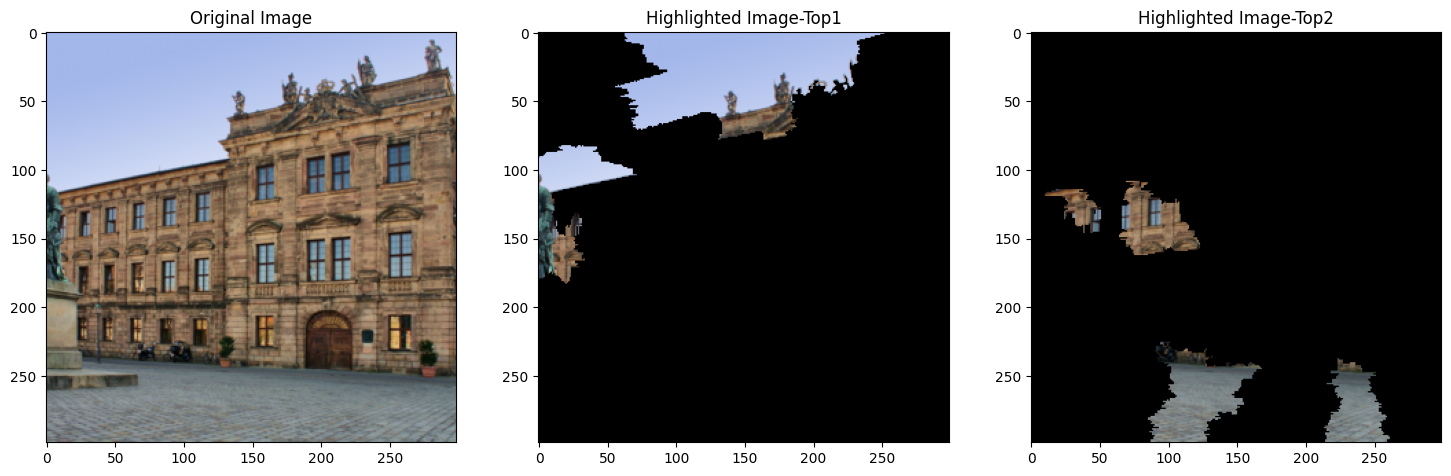

In [10]:
print(f"Top-1 Prediction: {img1_top1_cls} (Probability: {img1_top1_prob:.4f})")
print(f"Top-2 Prediction: {img1_top2_cls} (Probability: {img1_top2_prob:.4f})")

# display the results

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img1_np)
axes[0].set_title('Original Image')
axes[1].imshow(highlighted_img1_top1)
axes[1].set_title('Highlighted Image-Top1')
axes[2].imshow(highlighted_img1_top2)
axes[2].set_title('Highlighted Image-Top2')
plt.show()

Top-1 Prediction: obelisk (Probability: 0.2223)
Top-2 Prediction: mosque (Probability: 0.1261)


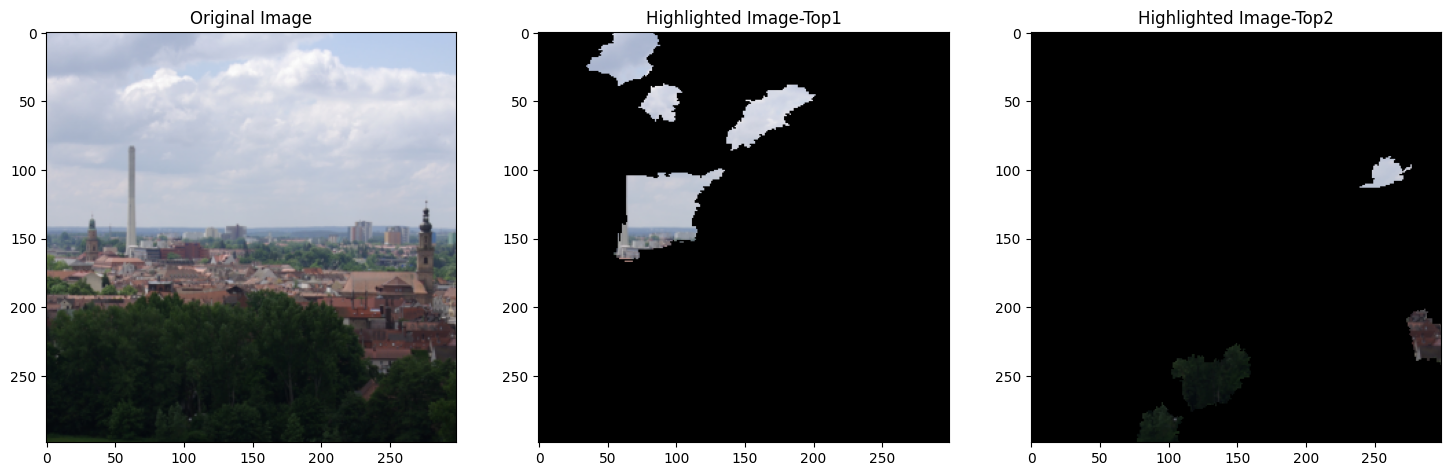

In [11]:
print(f"Top-1 Prediction: {img2_top1_cls} (Probability: {img2_top1_prob:.4f})")
print(f"Top-2 Prediction: {img2_top2_cls} (Probability: {img2_top2_prob:.4f})")

# display the results

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img2_np)
axes[0].set_title('Original Image')
axes[1].imshow(highlighted_img2_top1)
axes[1].set_title('Highlighted Image-Top1')
axes[2].imshow(highlighted_img2_top2)
axes[2].set_title('Highlighted Image-Top2')
plt.show()

Top-1 Prediction: tram (Probability: 0.1897)
Top-2 Prediction: palace (Probability: 0.1427)


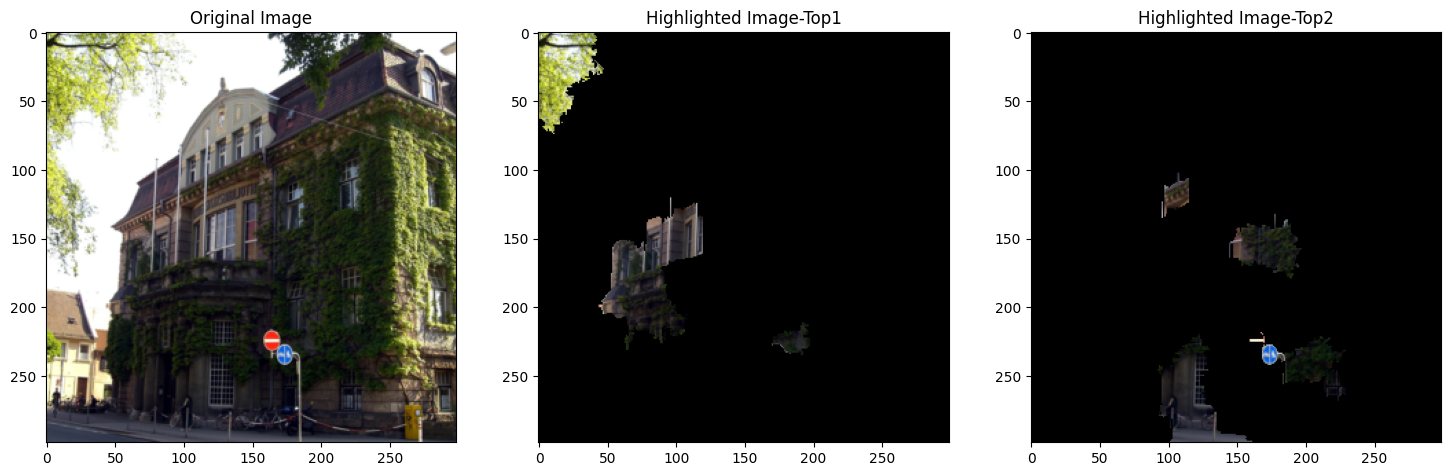

In [12]:
print(f"Top-1 Prediction: {img3_top1_cls} (Probability: {img3_top1_prob:.4f})")
print(f"Top-2 Prediction: {img3_top2_cls} (Probability: {img3_top2_prob:.4f})")

# display the results

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img3_np)
axes[0].set_title('Original Image')
axes[1].imshow(highlighted_img3_top1)
axes[1].set_title('Highlighted Image-Top1')
axes[2].imshow(highlighted_img3_top2)
axes[2].set_title('Highlighted Image-Top2')
plt.show()